In [2]:
%pylab inline
plt.style.use('../tweezepy.mplstyle')
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Robust paramater uncertainties
`Tweezepy` contains two different methods for calculating uncertainties. The first method relies on the Hessian of the maximum likelihood estimate. It is fast and sufficient for most circumstances; however, it relies on a Gaussian approximation that may not be valid in some cases (i.e., small sample sizes and parasitic noise). In these cases, a more robust option is to numerically sample the probability distribution of the parameters using a Markov Chain Monte Carlo (MCMC) sampler and estimate errors.

Here is an example showing how to use the MCMC method in `Tweezepy`.

## Simulate a downsampled trace
First, we'll simulate an example downsampled trace to mimic a single-molecule video-tracking system.

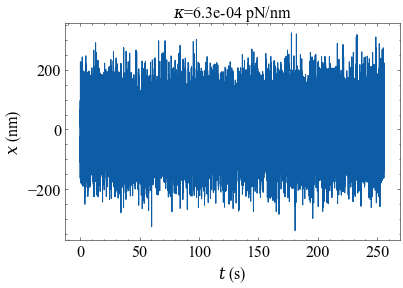

In [6]:
from tweezepy import downsampled_trace, PSD, AV
fc = 10 # corner frequency
gamma = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappa = gamma*2*np.pi*fc # kappa in pN/nm
fsample = 400 # sampling frequency in Hz
N  = 102400 # number of points in trajectory
seed = 0 # random seed for reproducibility
time = np.arange(N)/fsample
xtrace_ds = downsampled_trace(gamma,kappa,fsample,N, seed = seed)
plt.plot(time, xtrace_ds)
plt.xlabel('$t$ (s)')
plt.ylabel('$x$ (nm)')
plt.title(r'$\kappa$=%.1e pN/nm'%kappa)
plt.show()

### Calculate power spectral density (PSD) and fit it 
Now, we'll calculate the experimental PSD and fit it using maximum likelihood estimation.

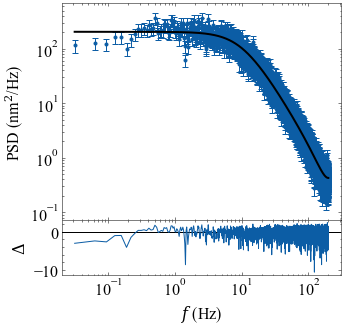

In [7]:
psd = PSD(xtrace_ds,fsample,bins = 15)
psd.mlefit()
psd.plot();

## Markov Chain Monte Carlo (MCMC) sampling
This tutorial won't go into how or why Monte Carlo sampling works. For more information on MCMC, I suggest checking out [Numerical Recipes](http://numerical.recipes/book/book.html). Rather, this tutorial shows how to use the MCMC 

Once a MLE fit is obtained, we can sample the parameter space using the `emcee` Python package. By default, 32 walkers are initialized in a tiny Gaussian ball around the MLE result and then run though 2,000 steps of MCMC.

100%|██████████| 2000/2000 [01:00<00:00, 32.81it/s]


(<Figure size 720x432 with 2 Axes>,
 [<AxesSubplot:ylabel='$\\gamma$ (pNs/nm)'>,
  <AxesSubplot:xlabel='step number', ylabel='$\\kappa$ (pN/nm)'>])

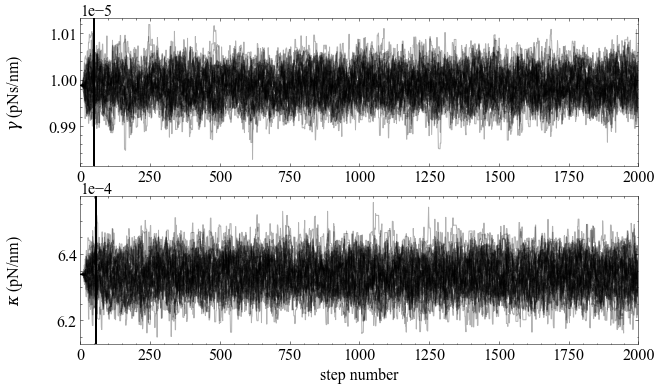

In [8]:
psd.mcmc()
psd.sample_plot(labels=[r"$\gamma$ (pNs/nm)",r"$\kappa$ (pN/nm)"])

This plot shows the positions of each walker as a function of the number of steps in the chain. As mentioned above, the walkers start in small Gaussian ball around the MLE results but quickly wander and explore the full paramater distribution. 

It takes the sampler some time to 'forget' the initial state, so we'll throw out twice the autocorrelation time (black vertical line). Then, we'll thin the samples by half the autocorrelation time to ensure the values at each step are uncorrelated. 

### Results
Now that we have a list of sampler positions, we can visualize the parameter distributions using a corner plot (i.e., the 1 and 2D histograms). This uses the corner package, which is separate from the emcee package. The MLE best-fit parameter estimates are indicated by the blue lines. The dotted black lines in the 1D histograms are the 16th and 84th percentiles. The black contour lines in the 2D histogram are the 1, 2, and 3 standard deviations.

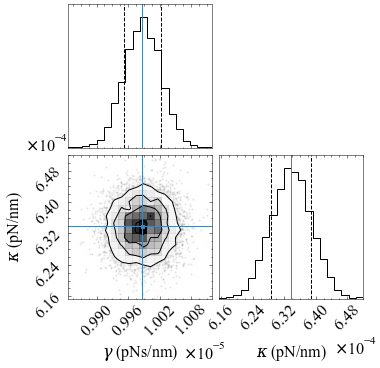

In [10]:
psd.corner_plot(labels=[r"$\gamma$ (pNs/nm)",r"$\kappa$ (pN/nm)"]);

The corner plot shows all the one and two dimensional projections of the parameter distributions. This is useful because it shows the covariances between parameters. After running the mcmc sampler, the one standard deviation errors are automatically added to the results dictionary.

In [10]:
# The mcmc results are automatically added to the results dictionary
psd.results

{'chi2': 9541.523752905014,
 'redchi2': 1.4915622561990016,
 'g': 9.987274585927754e-06,
 'g_error': 4.939065221213263e-08,
 'k': 0.0006338066057220219,
 'k_error': 7.270886693644723e-06,
 'support': 1.0,
 'p-value': 0.0,
 'AIC': 13644.000903245327,
 'g_mcmc': 9.986848732432244e-06,
 'g_mcmc_error': 3.418940344871848e-08,
 'k_mcmc': 0.0006337286094969152,
 'k_mcmc_error': 5.291154044559593e-06}

The results can be accessed directly through the results dictionary.

In [11]:
from IPython.display import display, Math
txt = r"$\gamma = %.1e\pm%.1e\textrm{ pNs/nm}$"%(psd.results['g_mcmc'],psd.results['g_mcmc_error'])
display(Math(txt))
txt = r"$\kappa = %.1e\pm%.1e\textrm{ pN/nm}$"%(psd.results['k_mcmc'],psd.results['k_mcmc_error'])
display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>